In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Problem 1**

One can analytically predict what the metallicity distribution function of the Milky Way would be if the Milky Way were a closed box. One feature of the predicted MDF is that nearly half of all stars in the local disk should have Z < Z_sun/4. The observed fraction is much lower than half -- it's somewhere between 0.01 and 0.2, depending on which element you look at. There aren't nearly as many metal-poor stars as the closed box model predicts.

One possible solution is that the gas was pre-enriched -- say, by population III stars. One can get about the right MDF by setting Z(t=0) = 0.15 Z_sun. 

Another possibile solution is that the disk continued to accrete pristine gas as it evolved. In this case, the pristine gas reservoir at early times would be smaller than in the closed box case, so the first stars would more efficiently pollute it with metals.

In [2]:
Z4_mags = [-22.69, -22.19, -21.69, -21.19, -20.69, -20.19, -19.69, -19.19, -18.69, -18.19, -17.69, -16.94, -15.94]
Z4_phis = [0.000003, 0.000015, 0.000134, 0.000393, 0.000678, 0.001696, 0.002475, 0.002984, 0.005352, 
           0.006865, 0.010473, 0.024580, 0.025080]
Z4_phi_errs = [0.000004, 0.000009, 0.000023, 0.000040, 0.000063, 0.000113, 0.000185, 0.000255, 0.000446, 0.001043,
                0.002229, 0.003500, 0.007860]
Z4_mags, Z4_phis, Z4_phi_errs = np.array(Z4_mags), np.array(Z4_phis), np.array(Z4_phi_errs)
Z4_log_phi_errs = np.sqrt((Z4_phi_errs/(Z4_phis*np.log(10)))**2)

Z6_mags = [-22.52, -22.02, -21.52, -21.02, -20.52, -20.02, -19.52, -18.77, -17.77, -16.77]
Z6_phis = [0.000002, 0.000015, 0.000053, 0.000176, 0.000320, 0.000698, 0.001246, 0.001900, 0.006680, 0.013640]
Z6_phi_errs = [0.000002, 0.000006, 0.000012, 0.000025, 0.000041, 0.000083, 0.000137, 0.000320, 0.001380, 0.004200]
Z6_mags, Z6_phis, Z6_phi_errs = np.array(Z6_mags), np.array(Z6_phis), np.array(Z6_phi_errs)
Z6_log_phi_errs = np.sqrt((Z6_phi_errs/(Z6_phis*np.log(10)))**2)

Z8_mags = [-21.87, -21.37, -20.87, -20.37, -19.87, -19.37, -18.62, -17.62]
Z8_phis = [0.000005, 0.000013, 0.000058, 0.000060, 0.000331, 0.000533, 0.001060, 0.002740]
Z8_phi_errs = [0.000003, 0.000005, 0.000015, 0.000026, 0.000104, 0.000226, 0.000340, 0.001040]
Z8_mags, Z8_phis, Z8_phi_errs = np.array(Z8_mags), np.array(Z8_phis), np.array(Z8_phi_errs)
Z8_log_phi_errs = np.sqrt((Z8_phi_errs/(Z8_phis*np.log(10)))**2)


In [3]:
# Problem 2
# as usual, it's a good idea to fit these functions in log space
import emcee
from mcmc import get_good_p0_ball, theta_is_within_bounds, ln_flat_prior

def log_Schechter(M, M_star, log_phi_star, alpha):
    '''
    log of Schechter function with convention of Bouwens et al 2015. 
    '''
    first = log_phi_star + np.log10(np.log(10) / 2.5)
    second = -0.4 * (M - M_star) * (alpha + 1)
    third = -(1/np.log(10))*10**(-0.4*(M - M_star))
    return first + second + third

def ln_likelihood_Schechter(theta, x_data, y_data, yerr):
    '''
    theta = M_star, log_phi_star, alpha 
    assuming gaussian errors (Note Poisson errors might be more correct)
    '''
    M_star, log_phi_star, alpha = theta
    y_hat = log_Schechter(M = x_data, M_star = M_star, 
                log_phi_star = log_phi_star, alpha = alpha)
    
    return -0.5*(np.sum((y_data - y_hat)**2/yerr**2))   

def ln_post(theta, theta_bounds, x_data, y_data, yerr):
    '''
    ln_prior + ln_likelihood
    '''
    lnprior = ln_flat_prior(theta = theta, theta_bounds = theta_bounds)
    
    if np.isfinite(lnprior):
        lnlikelihood = ln_likelihood_Schechter(theta = theta, 
            x_data = x_data, y_data = y_data, yerr = yerr)
    else:
        lnlikelihood = 0 
    return lnprior + lnlikelihood


def run_mcmc_Schechter(p0, theta_bounds, x_data, y_data, yerr, 
                  nwalkers = 100, n_steps = 500, burn = 50):
    '''
    returns a sampler object
    '''
    ndim = len(p0)
    p0_ball = get_good_p0_ball(p0 = p0, theta_bounds = theta_bounds, nwalkers = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[theta_bounds, x_data, y_data, yerr])
    pos, prob, state = sampler.run_mcmc(p0_ball, burn)
    
    sampler.reset()
    print('completed burn in ...')
    
    # now the main production run
    sampler.run_mcmc(pos, n_steps)
    return sampler


finished initializing walkers...
completed burn in ...


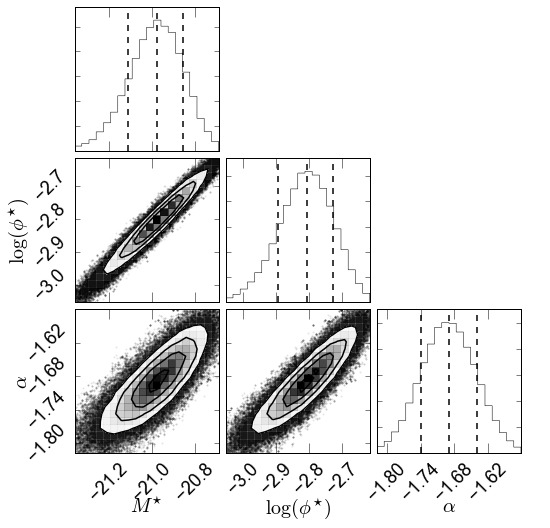

In [4]:
# first Z=4
p0 = [-21, -3.5, -2]

sampler4 = run_mcmc_Schechter(p0 = p0, theta_bounds = [[-23, -19], [-5, -2], [-4, 0]], 
                x_data = Z4_mags, y_data = np.log10(Z4_phis), yerr = Z4_log_phi_errs,
                nwalkers = 500, n_steps = 500, burn = 100)

import corner
fig = corner.corner(sampler4.flatchain, range = [0.99, 0.99, 0.99], 
        labels = [r'$M^{\star}$', r'$\log(\phi^{\star})$', r'$\alpha$'],
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])
axes = fig.get_axes()
for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)
Z4_median = np.median(sampler4.flatchain, axis=0)

finished initializing walkers...
completed burn in ...


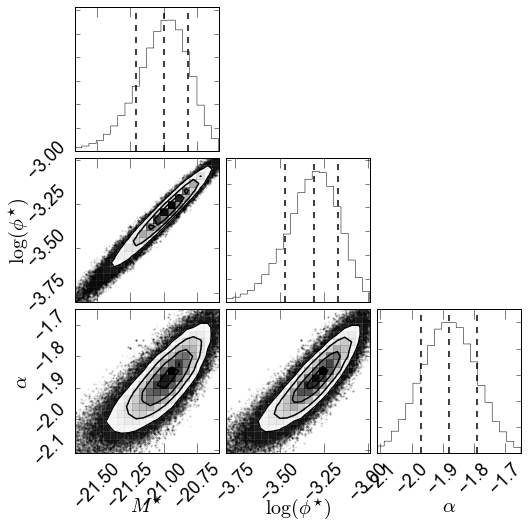

In [5]:
# then Z=6
sampler6 = run_mcmc_Schechter(p0 = p0, theta_bounds = [[-23, -19], [-5, -2], [-4, 0]], 
                x_data = Z6_mags, y_data = np.log10(Z6_phis), yerr = Z6_log_phi_errs,
                nwalkers = 500, n_steps = 500, burn = 100)

import corner
fig = corner.corner(sampler6.flatchain, range = [0.99, 0.99, 0.99], 
        labels = [r'$M^{\star}$', r'$\log(\phi^{\star})$', r'$\alpha$'],
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])
axes = fig.get_axes()
for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)
Z6_median = np.median(sampler6.flatchain, axis=0)

finished initializing walkers...
completed burn in ...


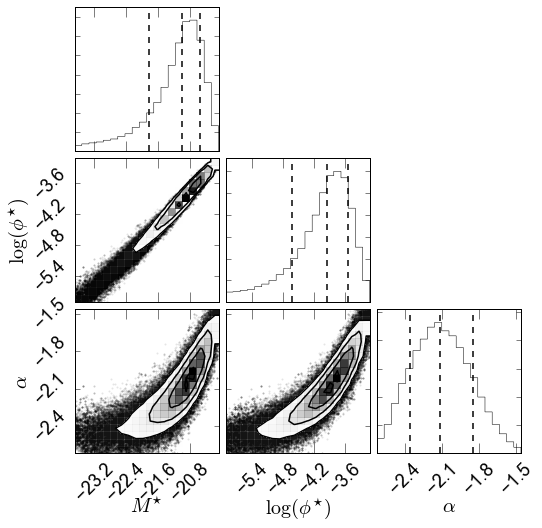

In [6]:
# then Z=8
sampler8 = run_mcmc_Schechter(p0 = p0, theta_bounds = [[-24, -18], [-6, -2], [-4, 0]], 
                x_data = Z8_mags, y_data = np.log10(Z8_phis), yerr = Z8_log_phi_errs,
                nwalkers = 500, n_steps = 500, burn = 100)
import corner
fig = corner.corner(sampler8.flatchain, range = [0.99, 0.99, 0.99], 
        labels = [r'$M^{\star}$', r'$\log(\phi^{\star})$', r'$\alpha$'],
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])
axes = fig.get_axes()
for i, ax in enumerate(axes):
    ax.grid(False)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.xaxis.set_tick_params(labelsize = 18)
Z8_median = np.median(sampler8.flatchain, axis=0)

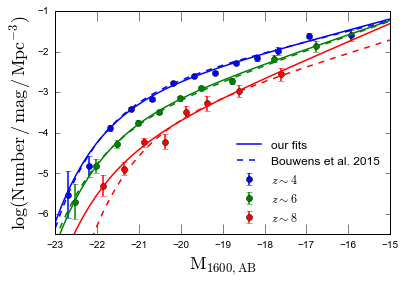

In [7]:
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
ax.set_xlim(-23, -15)
ax.set_ylim(-6.5, -1)
ax.errorbar(Z4_mags, np.log10(Z4_phis), yerr = Z4_log_phi_errs, fmt = 'bo', label = '$z \sim 4$')
ax.errorbar(Z6_mags, np.log10(Z6_phis), yerr = Z6_log_phi_errs, fmt = 'go', label = '$z \sim 6$')
ax.errorbar(Z8_mags, np.log10(Z8_phis), yerr = Z8_log_phi_errs, fmt = 'ro', label = '$z \sim 8$')
xx = np.linspace(-23, -15)
y4 = log_Schechter(M = xx, M_star = Z4_median[0], log_phi_star = Z4_median[1], alpha = Z4_median[2])
y6 = log_Schechter(M = xx, M_star = Z6_median[0], log_phi_star = Z6_median[1], alpha = Z6_median[2])
y8 = log_Schechter(M = xx, M_star = Z8_median[0], log_phi_star = Z8_median[1], alpha = Z8_median[2])

y4b = log_Schechter(M = xx, M_star = -20.88, log_phi_star = np.log10(1.97e-3), alpha = -1.64)
y6b = log_Schechter(M = xx, M_star = -21.10, log_phi_star = np.log10(0.39e-3), alpha = -1.90)
y8b = log_Schechter(M = xx, M_star = -20.19, log_phi_star = np.log10(0.44e-3), alpha = -1.81)

ax.plot(xx, y4, 'b-', label = 'our fits')
ax.plot(xx, y6, 'g-')
ax.plot(xx, y8, 'r-')
ax.plot(xx, y4b, 'b--', label = 'Bouwens et al. 2015')
ax.plot(xx, y6b, 'g--')
ax.plot(xx, y8b, 'r--')
ax.set_ylabel(r'$\log(\rm Number\,/\,mag\,/\,Mpc^{-3})$', fontsize = 18)
ax.set_xlabel(r'$\rm M_{1600,AB}$', fontsize = 18)
ax.legend(loc = 'best', frameon = False)



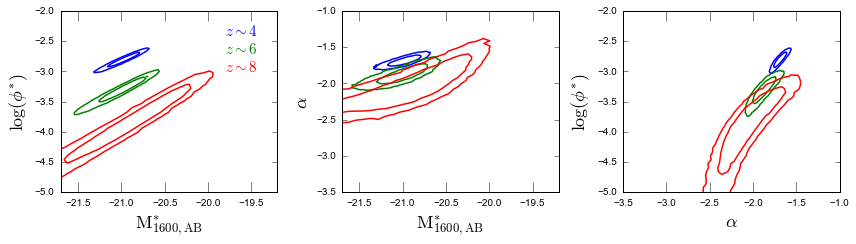

In [8]:
from mcmc import compute_sigma_level, plot_MCMC_trace

fig, ax = plt.subplots(1, 3, figsize = (12, 3.5))
plot_MCMC_trace(ax[0], sampler4.flatchain[:, 0], sampler4.flatchain[:, 1], colors = 'b')
plot_MCMC_trace(ax[0], sampler6.flatchain[:, 0], sampler6.flatchain[:, 1], colors = 'g')
plot_MCMC_trace(ax[0], sampler8.flatchain[:, 0], sampler8.flatchain[:, 1], colors = 'r')
ax[0].set_xlim(-21.7, -19.2)
ax[0].set_ylim(-5, -2)
ax[0].set_xlabel(r'$\rm M_{1600,AB}^{*}$', fontsize = 18)
ax[0].set_ylabel(r'$\log(\phi^{*})$', fontsize = 18)

plot_MCMC_trace(ax[1], sampler4.flatchain[:, 0], sampler4.flatchain[:, 2], colors = 'b')
plot_MCMC_trace(ax[1], sampler6.flatchain[:, 0], sampler6.flatchain[:, 2], colors = 'g')
plot_MCMC_trace(ax[1], sampler8.flatchain[:, 0], sampler8.flatchain[:, 2], colors = 'r')
ax[1].set_xlim(-21.7, -19.2)
ax[1].set_ylim(-3.5, -1)
ax[1].set_xlabel(r'$\rm M_{1600,AB}^{*}$', fontsize = 18)
ax[1].set_ylabel(r'$\alpha$', fontsize = 18)

plot_MCMC_trace(ax[2], sampler4.flatchain[:, 2], sampler4.flatchain[:, 1], colors = 'b')
plot_MCMC_trace(ax[2], sampler6.flatchain[:, 2], sampler6.flatchain[:, 1], colors = 'g')
plot_MCMC_trace(ax[2], sampler8.flatchain[:, 2], sampler8.flatchain[:, 1], colors = 'r')
ax[2].set_ylim(-5, -2)
ax[2].set_xlim(-3.5, -1)
ax[2].set_xlabel(r'$\alpha$', fontsize = 18)
ax[2].set_ylabel(r'$\log(\phi^{*})$', fontsize = 18)
ax[0].text(-19.8, -2.4, r'$z\sim 4$', color = 'b', fontsize = 15)
ax[0].text(-19.8, -2.7, r'$z\sim 6$', color = 'g', fontsize = 15)
ax[0].text(-19.8, -3.0, r'$z\sim 8$', color = 'r', fontsize = 15)

plt.tight_layout()

# compare to figure 7 of Bouwens et al. 2015

Our fits are in good agreement with Bouwens et al. 2015 for z=4 and z=6; the best-fit values and marginalized 1 and 2 sigma probability contours shown above are basically identical to those in their Figure 7. 

The probability contours are *not* identical for $z=8$. Comparing our fit and theirs in the other figure, it looks like ours are a better fit. However, I didn't use the upper limit data points in the fit, because I wasn't sure what the right way to model an upper limit it. I suspect that's the main source of the discrepancy.

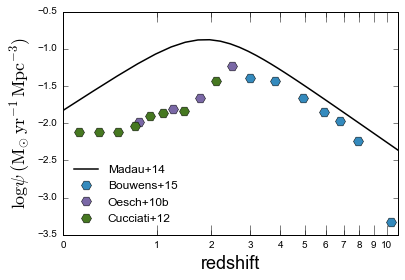

In [20]:
# problem 3

# For 3.0 < z < 10.4, I took the data from from Bouwens et al 2015 (Table 6)
# For lower redshifts, I combined data from Oesch et al 2010b and Cucciati et al. 2012.
# Because copying and pasting data from pdfs is slow and unsatisfying, I didn't 
# keep track of the errors. I know this is bad. 

Cucciati_Z = [0.125, 0.3, 0.5, 0.7, 0.9, 1.1, 1.45, 2.1]
Cucciati_Ms = [-18.6, -18.3, -18.4, -18.3, -18.7, -19.0, -19.6, -20.7]
Cucciati_phis = [5.36, 6.91, 6.60, 9.53, 9.01, 7.43, 4.10, 2.23]
Cucciati_alpha = [-1.1, -1.17, -1.07, -0.90, -0.85, -0.91, -1.09, -1.65]

Oesch_Z = [0.75, 1.25, 1.75, 2.5]
Oesch_Ms = [-19.17, -20.08, -20.17, -20.69]
Oesch_phis = [10**(-2.52)*1e3, 10**(-2.90)*1e3, 10**(-2.63)*1e3, 10**(-2.49)*1e3]
Oesch_alpha = [-1.52, -1.84, -1.60, -1.73]

Bouwens_Z = [3.0, 3.8, 4.9, 5.9, 6.8, 7.9, 10.4]
Bouwens_Ms = [-20.97, -20.88, -21.17, -20.94, -20.87, -20.63, -20.92]
Bouwens_phis = [1.71, 1.97, 0.74, 0.50, 0.29, 0.21, 0.008]
Bouwens_alpha = [-1.73, -1.64, -1.76, -1.87, -2.06, -2.02, -2.27]


def get_Lnu_from_MUV(M_ab):
    pc = 3.086e18 # cm 
    log_Fnu = -(2/5)*(M_ab + 48.6)
    Fnu = 10**(log_Fnu)
    dist_cm = 10*pc
    Lnu = Fnu * 4 * np.pi * dist_cm**2
    return Lnu

def get_rho_FUV_from_LF(M_star, phi_star, alpha, L_min = 0.03):
    '''
    equation 14 of Madau & Dickenson 2014. L_min in units of L_star.
    '''
    import sympy
    L_nu_star = get_Lnu_from_MUV(M_star)
    return float(sympy.mpmath.gammainc(2 + alpha, L_min)*L_nu_star*phi_star)
    
def get_sfr_density(M_star, phi_star, alpha, L_min = 0.03):
    '''
    rho_FUV should be in ergs/s/Hz/Mpc^3
    '''
    rho_FUV = get_rho_FUV_from_LF(M_star = M_star, phi_star = phi_star,
                alpha = alpha, L_min = L_min)
    K_FUV = np.log10(1/1.15e-28) # relation from Madau+14, based on a Salpeter IMF
    log_SFR = np.log10(rho_FUV) - K_FUV
    return log_SFR

def madau_dickenson_log_psi_z(z):
    psi = 0.015*(1 + z)**2.7/(1 + ((1 + z)/2.9)**5.6)
    return np.log10(psi)

B_sfrd = [get_sfr_density(M_star = mstar, phi_star = 1e-3*Bouwens_phis[i], 
        alpha = Bouwens_alpha[i], L_min = 0.03) for i, mstar in enumerate(Bouwens_Ms)]

O_sfrd = [get_sfr_density(M_star = mstar, phi_star = 1e-3*Oesch_phis[i], 
        alpha = Oesch_alpha[i], L_min = 0.03) for i, mstar in enumerate(Oesch_Ms)]

C_sfrd = [get_sfr_density(M_star = mstar, phi_star = 1e-3*Cucciati_phis[i], 
        alpha = Cucciati_alpha[i], L_min = 0.03) for i, mstar in enumerate(Cucciati_Ms)]
    
f = plt.figure()
ax = f.add_subplot(111)
ax.set_xlim(1, 12)
zz = np.linspace(0, 12)
ax.semilogx((1 + zz), madau_dickenson_log_psi_z(zz), 'k', label = 'Madau+14')
ax.semilogx((1 + np.array(Bouwens_Z)), B_sfrd, 'H', markersize = 10,
            label = 'Bouwens+15')
ax.semilogx((1 + np.array(Oesch_Z)), O_sfrd, 'H', markersize = 10,
            label = 'Oesch+10b')
ax.semilogx((1 + np.array(Cucciati_Z)), C_sfrd, 'H', markersize = 10,
            label = 'Cucciati+12')
zp1_ticks = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticks(zp1_ticks)
ax.set_xticklabels(zp1_ticks - 1)
ax.legend(loc = 'best', frameon = False, fontsize=12)
ax.set_xlabel('redshift', fontsize = 18)
ax.set_ylabel(r'$\log\psi\,(\rm M_{\odot}\,yr^{-1}\,Mpc^{-3})$', fontsize = 18)

In [21]:
# My derived SFRs are systemically too low when compared to the cosmic SFR from Madau+14. 
# comparing to Figure 18 from Bouwens+2015, it looks like the reason for this is that I'm not doing any dust
# correction, while Madau+14 used the IRX-beta relation from Meurer+1999. My data points look pretty similar
# to those in Figure 18 of Bouwens+2015 without the dust correction, and to the points in Finkelstein+2015 
# before the dust correction. 

# I didn't get around to fitting the SFRD function, but clearly if I had fit the function, I'd have gotten a lower 
# normalization and shallower low-redshift slope than Madau+14 and Finkelstein+15. I think the dominant source
# of the discrepancy is definitely the lack of dust correction. 